In [1]:
import os
import pandas as pd
from io import StringIO
import numpy as np
import scipy.signal
from scipy.signal import savgol_filter

def read_data_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    header_end_index = None
    for i, line in enumerate(lines):
        if '***End_of_Header***' in line:
            header_end_index = i
            break
    data_lines = lines[header_end_index + 2:]
    data_string = ''.join(data_lines)
    df = pd.read_csv(StringIO(data_string), sep='\t', names=['useless', 'x', 'y'])
    df = df.drop(columns=['useless'])
    assert len(df.columns) == 2
    assert df['x'].dtype == 'float64'
    assert df['y'].dtype == 'float64'
    return df


data_file_names = [i for i in os.listdir('241007/demo 1 data/0-9') if i.endswith('.data')]
extract_configs = {}
data = {}
for file_name in data_file_names:
    _data = read_data_file(f'241007/demo 1 data/0-9/{file_name}')
    extract_configs[file_name] = {'x_col': 1, 'y_col': 2}
    data[file_name] = _data

data_keys = list(data.keys())

In [2]:
inference_patterns = [i for i in os.listdir('241007/demo 1 data/Uchicago pattern') if i.endswith('.data')]
inference_pattern_data = {}
for file_name in inference_patterns:
    inference_pattern_data[file_name] = read_data_file(f'241007/demo 1 data/Uchicago pattern/{file_name}')


<Axes: xlabel='x', ylabel='y'>

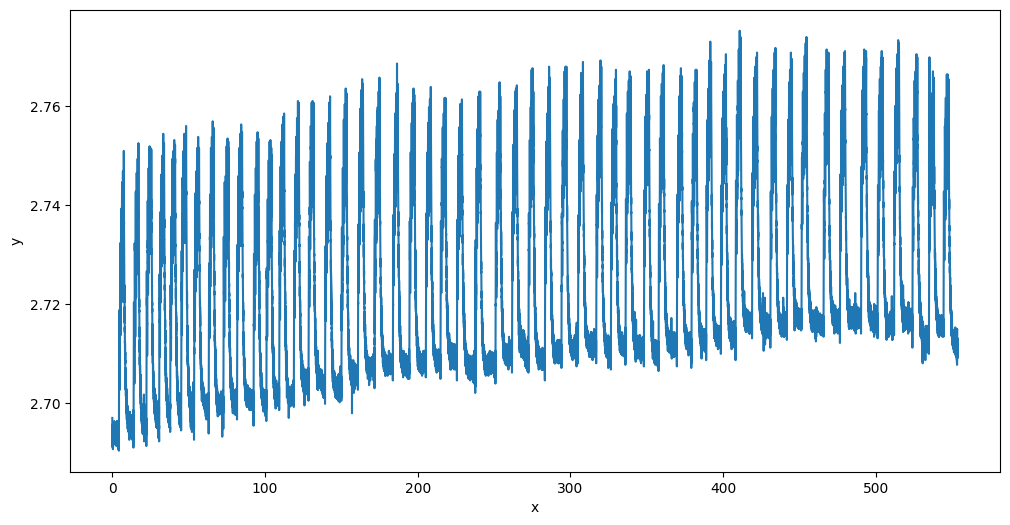

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
df = data['0 1.data']
sns.lineplot(x='x', y='y', data=df)


In [4]:
def find_stable_intervals(data, rolling_window=200, threshold=0.0025, smoothing_window=5, min_stable_length=10, transition='both'):
    df_first_index = data.index[0]
    bool_series = data.rolling(window=rolling_window).std() < threshold

    smoothed_series = bool_series.rolling(window=smoothing_window, center=True).mean() > 0.5

    # Handle NaN values
    smoothed_series = smoothed_series.fillna(False)

    if transition == 'true_to_false':
        change_indexes = (smoothed_series.shift().astype(bool) & ~smoothed_series.astype(bool)).index[smoothed_series.shift().astype(bool) & ~smoothed_series.astype(bool)]
    elif transition == 'false_to_true':
        change_indexes = (~smoothed_series.shift().astype(bool) & smoothed_series.astype(bool)).index[~smoothed_series.shift().astype(bool) & smoothed_series.astype(bool)]
    else:  # 'both'
        raise ValueError("Invalid transition type")

    filtered_changes = []
    for i in range(len(change_indexes)):
        if i == 0:
            if change_indexes[i] >= min_stable_length:
                filtered_changes.append(change_indexes[i])
        elif i == len(change_indexes) - 1:
            if len(smoothed_series) - change_indexes[i] >= min_stable_length:
                filtered_changes.append(change_indexes[i])
        else:
            if change_indexes[i] - change_indexes[i-1] >= min_stable_length:
                filtered_changes.append(change_indexes[i])

    # print(filtered_changes)
    min_indexes = []
    for idx in filtered_changes:
        start = max(0, idx - 30)
        end = min(len(data) - 1, idx + 31)
        window = data.iloc[start:end]
        # print(start, end, len(window), data.index[0] - df_first_index, data.index[-1] - df_first_index)
        if len(window) == 0:
            continue
        # min_idx = start + window.idxmin() - window.index[0]
        min_idx = window.idxmin() - df_first_index # still bugs here
        min_indexes.append(min_idx)

    return min_indexes

In [5]:
def savgol_find_peaks(arr, half_window_size=20, high_peak=True):
    savgol_arr = savgol_filter(arr, window_length=50, polyorder=2)
    if high_peak:
        peaks, _ = scipy.signal.find_peaks(savgol_arr, prominence=0.001, distance=10)
    else:
        peaks, _ = scipy.signal.find_peaks(-savgol_arr, prominence=0.001, distance=10)
    # correct the index found by peak by taking the maximum or minimum of the original array
    corrected_peaks = []
    for peak in peaks:
        start = max(0, peak - half_window_size)
        end = min(len(arr), peak + half_window_size + 1)
        window = arr[start:end]
        if high_peak:
            local_argmax = np.argmax(window)
            corrected_peaks.append(start + local_argmax)
        else:
            local_argmin = np.argmin(window)
            corrected_peaks.append(start + local_argmin)
    return corrected_peaks


In [75]:
len(data[data_keys[0]])

56590

In [6]:
def locate_peaks(df, threshold=0.0025):
    df = df.copy() # prevent side effect
    df_first_index = df.index[0]
    assert 'x' in df.columns and 'y' in df.columns
    # max_peaks, _ = scipy.signal.find_peaks(df['y'].to_numpy(), prominence=0.01, distance=500)
    # only the start_indexes preserved the original index, the others start from 0
    start_indexes = [i - df_first_index for i in find_stable_intervals(df['y'], threshold=threshold, transition='true_to_false')]
    freq_min_peaks_index = savgol_find_peaks(df['y'].to_numpy(), half_window_size=20, high_peak=False)
    freq_max_peaks_index = savgol_find_peaks(df['y'].to_numpy(), half_window_size=20, high_peak=True)
    segments = []
    for idx, start_index in enumerate(start_indexes):
        info_dict = {}
        info_dict['start_index'] = start_index
        info_dict['end_index'] = start_indexes[idx+1] - 1 if idx < len(start_indexes) - 1 else len(df) - 1
        info_dict['min_peaks_index'] = [idx for idx in freq_min_peaks_index if start_index <= idx <= info_dict['end_index']]
        info_dict['max_peaks_index'] = [idx for idx in freq_max_peaks_index if start_index <= idx <= info_dict['end_index']]
        val_min = min(df['y'].iloc[start_index],
                      df['y'].iloc[info_dict['min_peaks_index']].min(),
                      df['y'].iloc[info_dict['max_peaks_index']].min())
        val_max = max(df['y'].iloc[start_index],
                      df['y'].iloc[info_dict['min_peaks_index']].max(),
                      df['y'].iloc[info_dict['max_peaks_index']].max())
        # min_peak_threshold = val_min + (val_max - val_min) / 3
        max_peak_threshold = val_min + (val_max - val_min) / 3
        # info_dict['min_peaks_index'] = [idx for idx in info_dict['min_peaks_index'] if df['y'].iloc[idx] > min_peak_threshold]
        info_dict['max_peaks_index'] = [idx for idx in info_dict['max_peaks_index'] if df['y'].iloc[idx] > max_peak_threshold]
        if len(info_dict['max_peaks_index']) > 0:
            info_dict['min_peaks_index'] = [idx for idx in info_dict['min_peaks_index'] if idx < info_dict['max_peaks_index'][-1]]

        # convert to int
        info_dict['start_index'] = int(info_dict['start_index'])
        info_dict['end_index'] = int(info_dict['end_index'])
        info_dict['min_peaks_index'] = [int(idx) for idx in info_dict['min_peaks_index']]
        info_dict['max_peaks_index'] = [int(idx) for idx in info_dict['max_peaks_index']]
        segments.append(info_dict)
    return segments


In [7]:
segs = locate_peaks(data[data_keys[1]][:5000].copy())
segs


[{'start_index': 319,
  'end_index': 1091,
  'min_peaks_index': [376, 435, 494, 554, 614],
  'max_peaks_index': [349, 409, 468, 531, 591, 644]},
 {'start_index': 1092,
  'end_index': 1881,
  'min_peaks_index': [1092, 1156, 1214, 1272, 1332, 1392],
  'max_peaks_index': [1126, 1188, 1249, 1311, 1366, 1427]},
 {'start_index': 1882,
  'end_index': 2717,
  'min_peaks_index': [1882, 1938, 1996, 2055, 2115, 2176],
  'max_peaks_index': [1913, 1973, 2036, 2096, 2154, 2213]},
 {'start_index': 2718,
  'end_index': 3558,
  'min_peaks_index': [2718, 2775, 2834, 2892, 2953, 3012],
  'max_peaks_index': [2749, 2812, 2873, 2933, 2993, 3051]},
 {'start_index': 3559,
  'end_index': 4398,
  'min_peaks_index': [3559, 3615, 3678, 3737, 3796, 3854],
  'max_peaks_index': [3593, 3655, 3716, 3776, 3837, 3894]},
 {'start_index': 4399,
  'end_index': 4999,
  'min_peaks_index': [4399, 4456, 4516, 4576, 4636, 4693],
  'max_peaks_index': [4432, 4492, 4554, 4614, 4674, 4733]}]

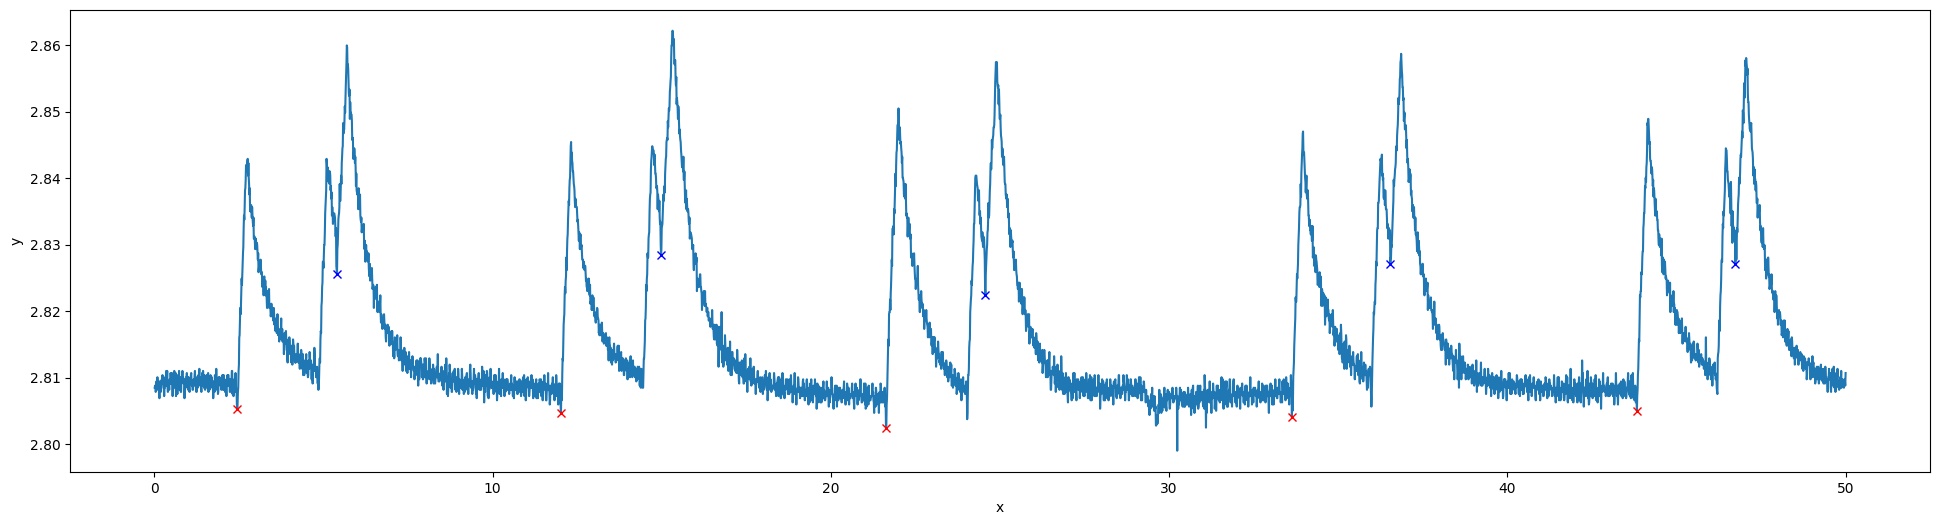

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

thres_dict = defaultdict(lambda: 0.0025)
thres_dict[27] = 0.006


plt.figure(figsize=(24, 6))


data_files = [f'{i} {j}.data' for i in range(10) for j in range(1, 5+1)]
data_index = 11
df = data[data_files[data_index]][:5000]
# df = data[data_files[5]]
# df['savgol'] = savgol_filter(df['y'], window_length=50, polyorder=2)
# df['moving_avg_std'] = df['y'].rolling(window=200).std()
sns.lineplot(data=df, x='x', y='y')
# sns.lineplot(data=df, x='x', y='savgol')

segs = locate_peaks(df, threshold=thres_dict[data_index])
# print(segs)

starts = []
last_peaks = []
for seg in segs:
    if len(seg['min_peaks_index']) > 0:
        starts.append(seg['start_index'])
        last_peaks.append(seg['min_peaks_index'][-1])

# starts = [i for i in starts if 1000 <= i <= 1999]
# last_peaks = [i for i in last_peaks if 1000 <= i <= 1999]
plt.plot(df.iloc[starts]['x'], df.iloc[starts]['y'], "x", color='r')
plt.plot(df.iloc[last_peaks]['x'], df.iloc[last_peaks]['y'], "x", color='b')
plt.show()


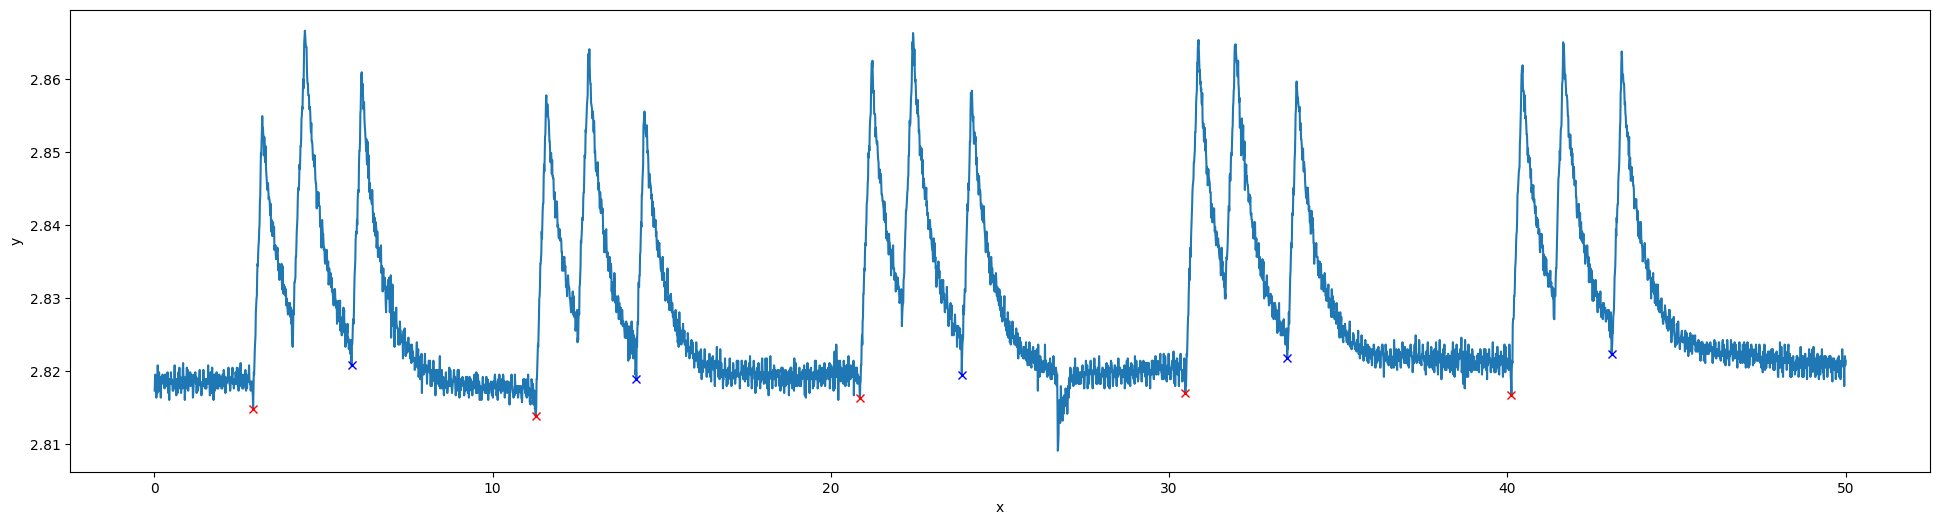

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

thres_dict = defaultdict(lambda: 0.0025)
thres_dict[27] = 0.006


plt.figure(figsize=(24, 6))


data_files = [f'{i} {j}.data' for i in range(10) for j in range(1, 5+1)]
data_index = 13
df = data[data_files[data_index]][:5000]
# df = data[data_files[5]]
# df['savgol'] = savgol_filter(df['y'], window_length=50, polyorder=2)
# df['moving_avg_std'] = df['y'].rolling(window=200).std()
sns.lineplot(data=df, x='x', y='y')
# sns.lineplot(data=df, x='x', y='savgol')

segs = locate_peaks(df, threshold=thres_dict[data_index])
# print(segs)

starts = []
last_peaks = []
for seg in segs:
    if len(seg['min_peaks_index']) > 0:
        starts.append(seg['start_index'])
        last_peaks.append(seg['min_peaks_index'][-1])

# starts = [i for i in starts if 1000 <= i <= 1999]
# last_peaks = [i for i in last_peaks if 1000 <= i <= 1999]
plt.plot(df.iloc[starts]['x'], df.iloc[starts]['y'], "x", color='r')
plt.plot(df.iloc[last_peaks]['x'], df.iloc[last_peaks]['y'], "x", color='b')
plt.show()


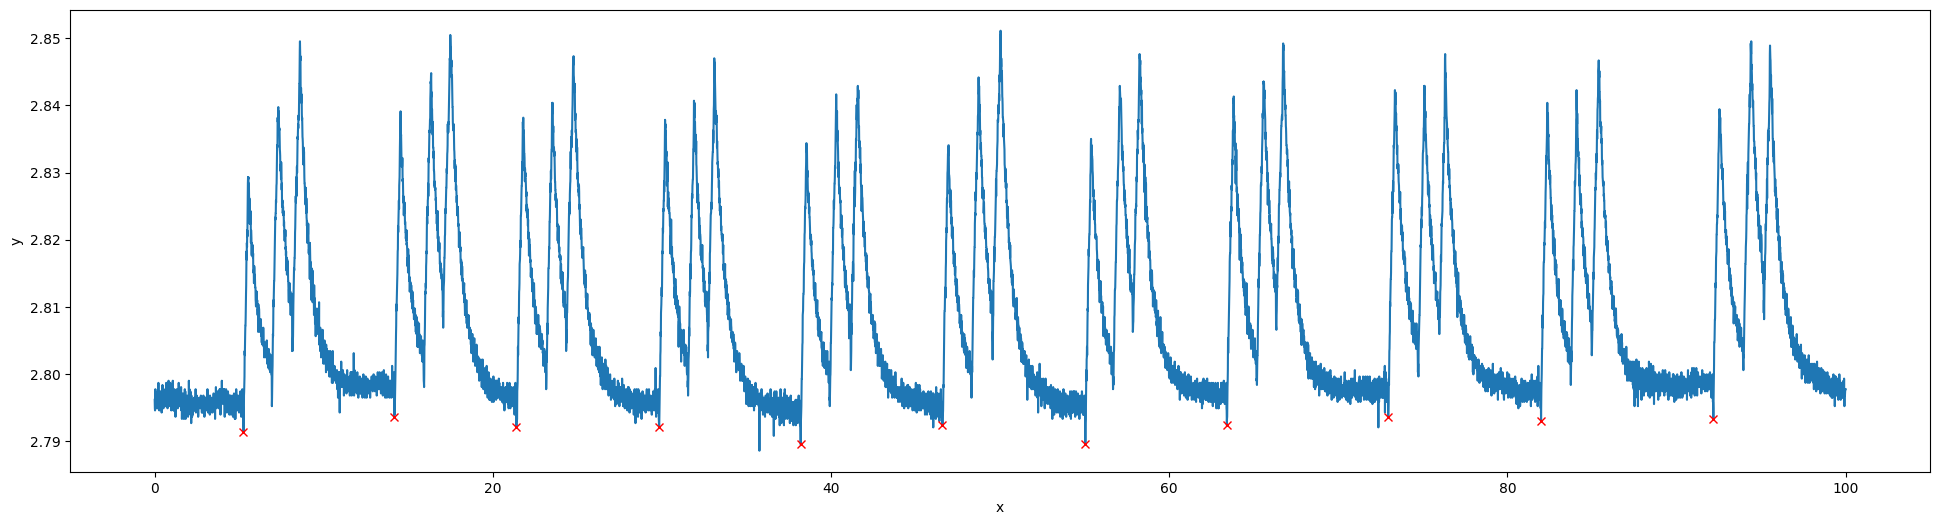

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(24, 6))
data_key = data_keys[-4]

data_files = [f'{i} {j}.data' for i in range(10) for j in range(1, 5+1)]
# df = data[data_files[5]][19000:23000]
df = data[data_files[9]][:10000].copy()
# df['savgol'] = savgol_filter(df['y'], window_length=50, polyorder=2)
# df['moving_avg_std'] = df['y'].rolling(window=200).std()
sns.lineplot(data=df, x='x', y='y')
# sns.lineplot(data=df, x='x', y='savgol')

start_indexes = [i for i in find_stable_intervals(df['y'], transition='true_to_false')]

plt.plot(df.iloc[start_indexes]['x'], df.iloc[start_indexes]['y'], "x", color='r')

plt.show()


In [ ]:
fails=[5,6,7,8,9,12,13,23,24,26,37,38,39]
partial_fails=[16,49]
low_quality=[18,27,28]
wrong_results=[21,30,31] # 1/3 is too low
needs_cleaning=[45,47]

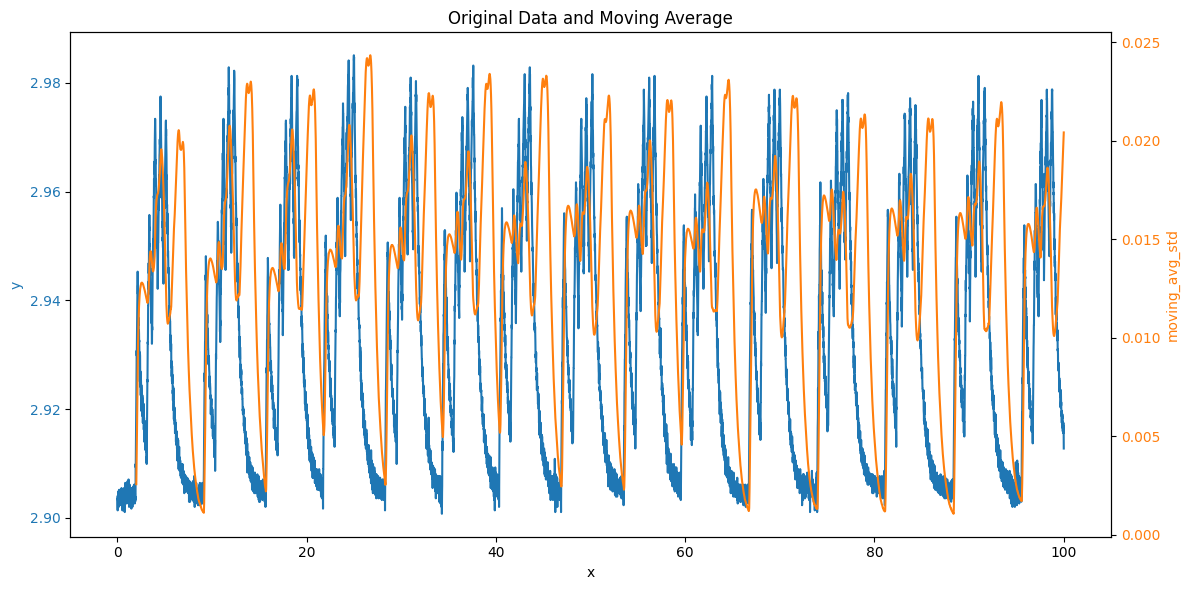

In [253]:
import matplotlib.pyplot as plt

df = data[data_files[27]][:10000].copy()

# Create a figure and a primary y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))
df['moving_avg_std'] = df['y'].rolling(window=200).std()

# Plot the first line (original data) on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('x')
ax1.set_ylabel('y', color=color)
ax1.plot(df['x'], df['y'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the second line (moving average) on the secondary y-axis
color = 'tab:orange'
ax2.set_ylabel('moving_avg_std', color=color)
ax2.plot(df['x'], df['moving_avg_std'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add a title
plt.title('Original Data and Moving Average')

# Adjust the layout and display the plot
fig.tight_layout()
plt.show()


In [ ]:
# save to files
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import json

thres_dict = defaultdict(lambda: 0.0025)
thres_dict[27] = 0.006


data_files = [f'{i} {j}.data' for i in range(10) for j in range(1, 5+1)]
for data_index in range(len(data_files)):
    target_dir = f'data/{data_files[data_index].replace(".data", "")}'
    os.makedirs(target_dir, exist_ok=True)
    df = data[data_files[data_index]]

    segs = locate_peaks(df, threshold=thres_dict[data_index])
    with open(f'{target_dir}/raw_segs.json', 'w') as f:
        json.dump(segs, f)

    starts = []
    last_peaks = []
    for seg in segs:
        if len(seg['min_peaks_index']) > 0:
            starts.append(seg['start_index'])
            last_peaks.append(seg['min_peaks_index'][-1])

    with open(f'{target_dir}/extracted_segs.json', 'w') as f:
        json.dump([{'index': i, 'start': starts[i], 'last_peak': last_peaks[i]} for i in range(len(starts))], f)

    for i in range(len(starts)):
        start_idx = starts[i]
        end_idx = starts[i+1] if i < len(starts) - 1 else len(df)
        sns.lineplot(data=df.iloc[start_idx:end_idx], x='x', y='y')
        plt.plot(df.iloc[start_idx]['x'], df.iloc[start_idx]['y'], "x", color='r')
        plt.plot(df.iloc[last_peaks[i]]['x'], df.iloc[last_peaks[i]]['y'], "x", color='b')
        plt.savefig(f'{target_dir}/{i}.png')
        plt.close()


79


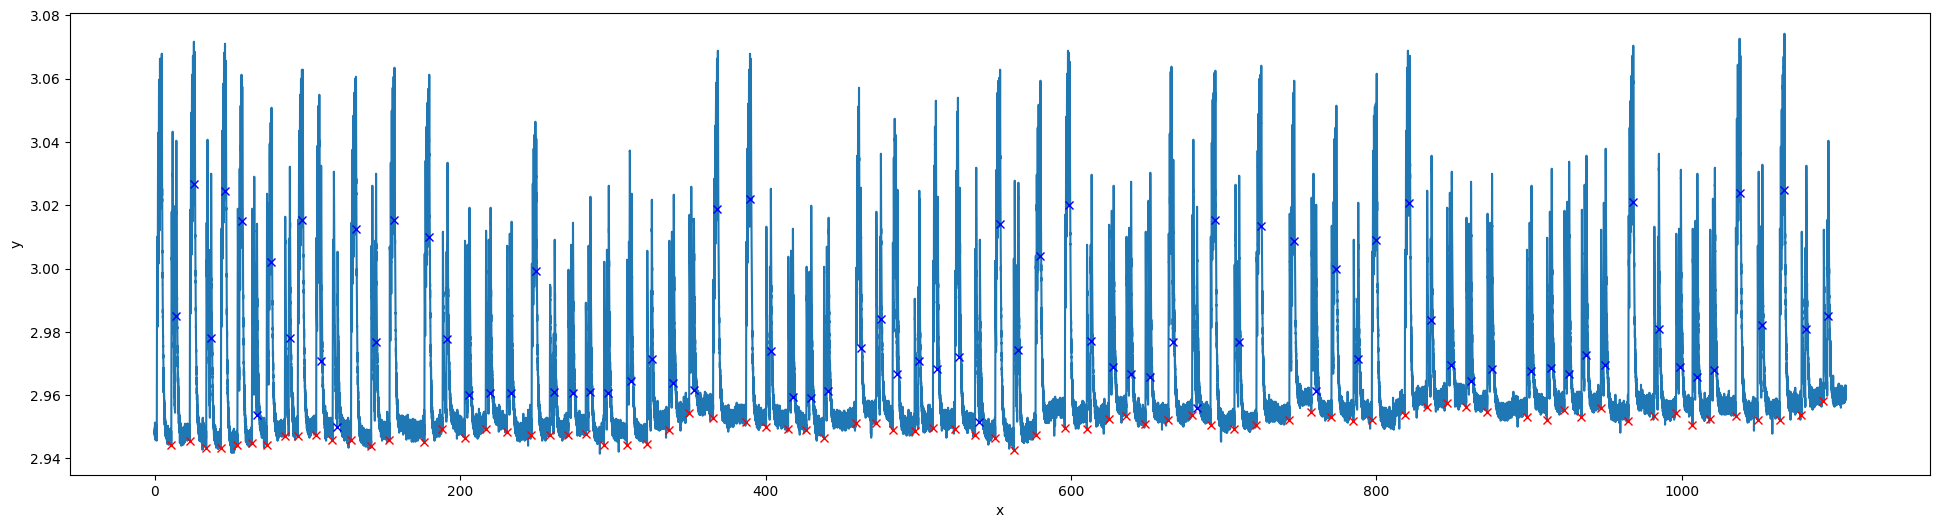

In [18]:
# inference pattern
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

thres_dict = defaultdict(lambda: 0.0025)


plt.figure(figsize=(24, 6))


data_files = ['uchicago.data', 'uchicago 2.data', 'uchicago 3.data']
data_index = 0
df = inference_pattern_data[data_files[data_index]]
# df = data[data_files[5]]
# df['savgol'] = savgol_filter(df['y'], window_length=50, polyorder=2)
# df['moving_avg_std'] = df['y'].rolling(window=200).std()
sns.lineplot(data=df, x='x', y='y')
# sns.lineplot(data=df, x='x', y='savgol')

segs = locate_peaks(df, threshold=0.0025)
# print(segs)

starts = []
last_peaks = []
for seg in segs:
    if len(seg['min_peaks_index']) > 0:
        starts.append(seg['start_index'])
        last_peaks.append(seg['min_peaks_index'][-1])

print(len(segs))

# starts = [i for i in starts if 1000 <= i <= 1999]
# last_peaks = [i for i in last_peaks if 1000 <= i <= 1999]
plt.plot(df.iloc[starts]['x'], df.iloc[starts]['y'], "x", color='r')
plt.plot(df.iloc[last_peaks]['x'], df.iloc[last_peaks]['y'], "x", color='b')
plt.show()


In [11]:
from collections import defaultdict
import json
import seaborn as sns
import matplotlib.pyplot as plt

data_files = ['uchicago.data', 'uchicago 2.data', 'uchicago 3.data']
thres_dict = defaultdict(lambda: 0.0025)
for data_index in range(len(data_files)):
    target_dir = f'uc_pattern/{data_files[data_index].replace(".data", "")}'
    os.makedirs(target_dir, exist_ok=True)
    df = inference_pattern_data[data_files[data_index]]

    segs = locate_peaks(df, threshold=thres_dict[data_index])
    with open(f'{target_dir}/raw_segs.json', 'w') as f:
        json.dump(segs, f)

    starts = []
    last_peaks = []
    for seg in segs:
        if len(seg['min_peaks_index']) > 0:
            starts.append(seg['start_index'])
            last_peaks.append(seg['min_peaks_index'][-1])

    with open(f'{target_dir}/extracted_segs.json', 'w') as f:
        json.dump([{'index': i, 'start': starts[i], 'last_peak': last_peaks[i]} for i in range(len(starts))], f)

    for i in range(len(starts)):
        start_idx = starts[i]
        end_idx = starts[i+1] if i < len(starts) - 1 else len(df)
        sns.lineplot(data=df.iloc[start_idx:end_idx], x='x', y='y')
        plt.plot(df.iloc[start_idx]['x'], df.iloc[start_idx]['y'], "x", color='r')
        plt.plot(df.iloc[last_peaks[i]]['x'], df.iloc[last_peaks[i]]['y'], "x", color='b')
        plt.savefig(f'{target_dir}/{i}.png')
        plt.close()